In [21]:
import netCDF4 as nc
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [108]:
import xarray as xr
import numpy as np

# Load the dataset
nc = 'data/model_output_soil_moisture.nc'
ds = xr.open_dataset(nc)

# Calculate mean daily soil moisture by day of the year
mean_daily_soil_moisture = ds.groupby('time.dayofyear').mean('time')

# Select the soil moisture variable if it's a data variable
if 'soil_moisture' in mean_daily_soil_moisture.data_vars:
    mean_daily_soil_moisture = mean_daily_soil_moisture['soil_moisture']

# Define the threshold
threshold = 300

# Calculate the daily difference from the threshold
daily_difference = mean_daily_soil_moisture - threshold

# Initialize the index array
index = xr.zeros_like(daily_difference)

# Process for each grid point separately
for lat in range(1, len(daily_difference.lat)):
    for lon in range(1, len(daily_difference.lon)):
        for n in range(2, len(daily_difference.dayofyear)):  # Assuming daily_difference has a 'dayofyear' dimension

            if daily_difference[n-1][lat][lon] > 0 and index[n-1][lat][lon] == 0:
                index[n][lat][lon] = 0
            elif daily_difference[n-1][lat][lon] < 0:
                index[n][lat][lon] = abs(daily_difference[n-1][lat][lon]) + index[n-1][lat][lon]
            elif daily_difference[n-1][lat][lon] > 0 and index[n-1][lat][lon] > 0:
                index[n][lat][lon] = index[n-1][lat][lon] - abs(daily_difference[n-1][lat][lon])
            elif index[n-1][lat][lon] < 0:
                index[n][lat][lon] = 0
                
index = index.where(index >= 0, 0)


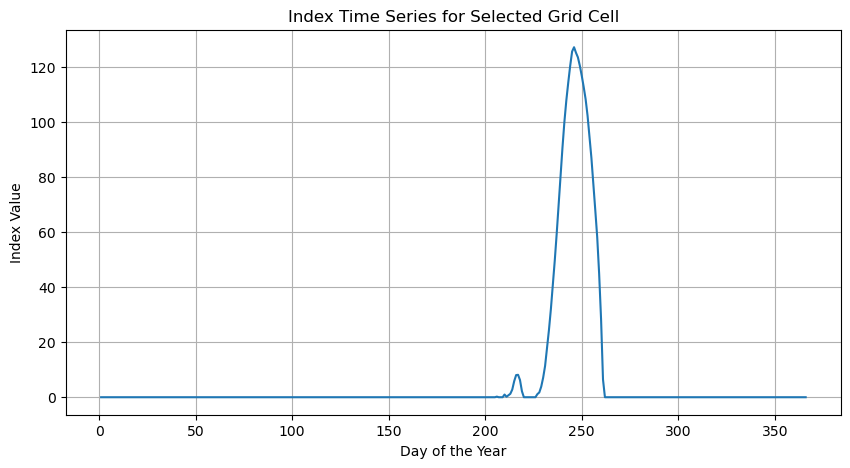

In [111]:
import matplotlib.pyplot as plt


# Select a specific grid cell, e.g., first lat and lon
specific_lat_lon_index = index.isel(lat=20, lon=21)

# Plotting the index time series for the selected grid cell
plt.figure(figsize=(10, 5))
specific_lat_lon_index.plot()
plt.title('Index Time Series for Selected Grid Cell')
plt.xlabel('Day of the Year')
plt.ylabel('Index Value')
plt.grid(True)
plt.show()


In [112]:
import xarray as xr

# Assuming 'index' is your xarray DataArray from previous steps

# 1) Calculate the number of days with index > 0 for each grid cell
index_len = (index > 0).sum(dim="dayofyear")

# 2) Calculate the maximum index for each grid cell
index_max = index.max(dim="dayofyear")

# 3) Calculate the sum of index for each grid cell
index_severity = index.sum(dim="dayofyear")

# Export each dataset to NetCDF files
index_len.to_netcdf('data/aggregated_over_years_model_input/index_len.nc')
index_max.to_netcdf('data/aggregated_over_years_model_input/index_max.nc')
index_severity.to_netcdf('data/aggregated_over_years_model_input/index_severity.nc')
